In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
from sklearn.impute import KNNImputer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
imp = KNNImputer(n_neighbors=7)

## Import Data

In [17]:
c=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/customer.csv')
p=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/product.csv')
o=pd.read_csv('/content/drive/MyDrive/Nykaa Ecommerce Project/Import Files/orders.csv')

## Null Value

In [18]:
# No Null Value

c.isna().sum()
p.isna().sum()
o.isna().sum()

,0
Or_ID,0
C_ID,0
P_ID,0
Order_Date,0
Order_Time,0
Qty,0
Coupon,0
DP_ID,0
Discount,0


## Duplicate values

In [19]:
# No duplicate

c.duplicated().sum()
p.duplicated().sum()
o.duplicated().sum()

np.int64(0)

## Data Merge

In [23]:
p.rename(columns={'Gender':'P_Gender'} ,inplace=True)

In [46]:
oc=pd.merge(o,c,on='C_ID',how='left' )
ocp=pd.merge(oc,p,on='P_ID',how='left')

## Check Null Value

In [47]:
ocp.isna().sum()

,0
Or_ID,0
C_ID,0
P_ID,0
Order_Date,0
Order_Time,0
Qty,0
Coupon,0
DP_ID,0
Discount,0
C_Name,0


## Feature Engineering

In [48]:
ocp.dtypes

,0
Or_ID,object
C_ID,object
P_ID,object
Order_Date,object
Order_Time,object
Qty,int64
Coupon,object
DP_ID,object
Discount,int64
C_Name,object


In [49]:
ocp['Order_Date']=pd.to_datetime(ocp['Order_Date'])
ocp['Order_Time']=pd.to_datetime(ocp['Order_Time'])

<ipython-input-49-af4b94d0d729>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ocp['Order_Time']=pd.to_datetime(ocp['Order_Time'])


In [50]:
ocp['Sales']=ocp['Qty']*ocp['Price']*(1-ocp['Discount']/100)

## Recency

In [51]:
recency= ocp.groupby('C_ID')['Order_Date'].max().reset_index()
recency['Recency'] = (ocp['Order_Date'].max() - recency['Order_Date']).dt.days
recency.head()

,C_ID,Order_Date,Recency
0,CS_11000001,2024-07-02,182
1,CS_11000003,2024-06-21,193
2,CS_11000004,2023-02-20,680
3,CS_11000005,2024-03-09,297
4,CS_11000007,2024-02-23,312


## Frequency

In [71]:
freq=ocp['C_ID'].value_counts().reset_index()
freq.columns=['C_ID','Frequency']
freq.head()

,C_ID,Frequency
0,CS_11008968,7
1,CS_11007611,6
2,CS_11005093,6
3,CS_11007911,6
4,CS_11008868,6


## Monetory

In [94]:
monetory=ocp.groupby('C_ID')['Sales'].sum().reset_index()
monetory.columns=['C_ID','Monetary']
monetory.head()

,C_ID,Monetary
0,CS_11000001,1879.1000
1,CS_11000003,1327.7600
2,CS_11000004,949.0272
3,CS_11000005,936.2920
4,CS_11000007,3444.6600


## Combine Recency, Fequency and Monetory

In [95]:
rf=pd.merge(recency,freq,on='C_ID')
rfm=pd.merge(rf,monetory,on='C_ID')

In [96]:
rf.head()

,C_ID,Order_Date,Recency,Frequency
0,CS_11000001,2024-07-02,182,1
1,CS_11000003,2024-06-21,193,2
2,CS_11000004,2023-02-20,680,1
3,CS_11000005,2024-03-09,297,1
4,CS_11000007,2024-02-23,312,1


In [97]:
rfm.head()

,C_ID,Order_Date,Recency,Frequency,Monetary
0,CS_11000001,2024-07-02,182,1,1879.1000
1,CS_11000003,2024-06-21,193,2,1327.7600
2,CS_11000004,2023-02-20,680,1,949.0272
3,CS_11000005,2024-03-09,297,1,936.2920
4,CS_11000007,2024-02-23,312,1,3444.6600


In [98]:
rfm.drop('Order_Date',axis=1,inplace=True)

In [99]:
rfm.head()

,C_ID,Recency,Frequency,Monetary
0,CS_11000001,182,1,1879.1000
1,CS_11000003,193,2,1327.7600
2,CS_11000004,680,1,949.0272
3,CS_11000005,297,1,936.2920
4,CS_11000007,312,1,3444.6600


## Decile Analysis

In [100]:
rfm.describe(percentiles=[0.2,0.4,0.6,0.8])

,Recency,Frequency,Monetary
count,6340.000000,6340.000000,6340.000000
mean,307.578549,1.577287,2005.370357
std,206.794905,0.811373,1701.987130
min,0.000000,1.000000,5.425000
20%,103.000000,1.000000,536.318000
40%,213.600000,1.000000,1204.669640
50%,280.000000,1.000000,1593.932500
60%,350.000000,2.000000,2046.655600
80%,521.000000,2.000000,3230.610000
max,730.000000,7.000000,14000.652000


## R_Score, F_Score and M_Score


In [101]:
rfm1=rfm.copy()

In [104]:
rfm1['R_Score']=pd.cut(rfm1['Recency'],bins=[-1,103,213.6,350,521,730],labels=[5,4,3,2,1])
rfm1['F_Score']=pd.cut(rfm1['Frequency'],bins=[0,1,1.01,2,2.01,7],labels=[1,2,3,4,5])
rfm1['M_Score']=pd.cut(rfm1['Monetary'],bins=[5.424,536.31,1204.669640,2046.6556,3230.61,14000.652],labels=[1,2,3,4,5])

In [105]:
rfm1.head()

,C_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,CS_11000001,182,1,1879.1000,4,1,3
1,CS_11000003,193,2,1327.7600,4,3,3
2,CS_11000004,680,1,949.0272,1,1,2
3,CS_11000005,297,1,936.2920,3,1,2
4,CS_11000007,312,1,3444.6600,3,1,5


In [106]:
rfm1['RF_Score']=rfm1['R_Score'].astype(str)+rfm1['F_Score'].astype(str)
rfm1['RFM_Score']=rfm1['R_Score'].astype(str)+rfm1['F_Score'].astype(str)+rfm1['M_Score'].astype(str)

In [107]:
rfm1.head()

,C_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RF_Score,RFM_Score
0,CS_11000001,182,1,1879.1000,4,1,3,41,413
1,CS_11000003,193,2,1327.7600,4,3,3,43,433
2,CS_11000004,680,1,949.0272,1,1,2,11,112
3,CS_11000005,297,1,936.2920,3,1,2,31,312
4,CS_11000007,312,1,3444.6600,3,1,5,31,315


## Segmentation of Customer

In [108]:
segment_rules = {
    '[1-2][1-2]' : 'Hibernating',
    '3[1-2]' : 'About to Sleep',
    '41' : 'Promising',
    '51' : 'New Customers',
    '33' : 'Needs Attention',
    '[4-5][2-3]' : 'Potential Loyalists',
    '[1-2][3-4]' : 'At Risk',
    '[1-2]5' : "Can't Lose",
    '[3-4][4-5]' : 'Loyal Customers',
    '5[4-5]': 'Champions'
}

In [109]:
rfm1['Segment']=rfm1['RF_Score'].replace(segment_rules,regex=True)

In [110]:
rfm1['R_Score']=rfm1['R_Score'].astype(int)
rfm1['F_Score']=rfm1['F_Score'].astype(int)
rfm1['M_Score']=rfm1['M_Score'].astype(int)

In [111]:
rfm1.head()

,C_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RF_Score,RFM_Score,Segment
0,CS_11000001,182,1,1879.1000,4,1,3,41,413,Promising
1,CS_11000003,193,2,1327.7600,4,3,3,43,433,Potential Loyalists
2,CS_11000004,680,1,949.0272,1,1,2,11,112,Hibernating
3,CS_11000005,297,1,936.2920,3,1,2,31,312,About to Sleep
4,CS_11000007,312,1,3444.6600,3,1,5,31,315,About to Sleep


## Cluster Profiling

In [113]:
rfm1.groupby(['Segment']).agg({'Segment':'count','Recency':'mean','Frequency':'mean','Monetary':'mean'})

,Segment,Recency,Frequency,Monetary
Segment,,,,
About to Sleep,685,284.541606,1.000000,1323.755616
At Risk,476,476.380252,2.000000,2516.950991
Can't Lose,92,441.934783,3.163043,4138.520729
Champions,287,46.358885,3.404181,4367.661301
Hibernating,1958,543.054137,1.000000,1244.634409
Loyal Customers,410,196.095122,3.260976,4078.124579
Needs Attention,443,276.817156,2.000000,2469.410649
New Customers,502,51.557769,1.000000,1333.257246
Potential Loyalists,925,101.819459,2.000000,2593.950975


## Plotting Graph

In [117]:
segm= rfm1['Segment'].value_counts().reset_index()
segm

,Segment,count
0,Hibernating,1958
1,Potential Loyalists,925
2,About to Sleep,685
3,Promising,562
4,New Customers,502
5,At Risk,476
6,Needs Attention,443
7,Loyal Customers,410
8,Champions,287
9,Can't Lose,92


In [126]:
fig = px.treemap(data_frame=segm,path=[px.Constant("all"),'Segment'],values='count',
                  color='Segment', title='RFM for Customer Segmentation',
                  color_discrete_sequence=["#496379","#5A7D9A","#3B4F63","#2F3A4F","#6D8EA4","#819BB0",
                                           "#ACBFD3", "#F3F5F7", "#2E4053", "#1C2833" ])

fig.update_traces(root_color="lightgrey")
fig.show()

<ipython-input-150-1a4be8c699b2>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




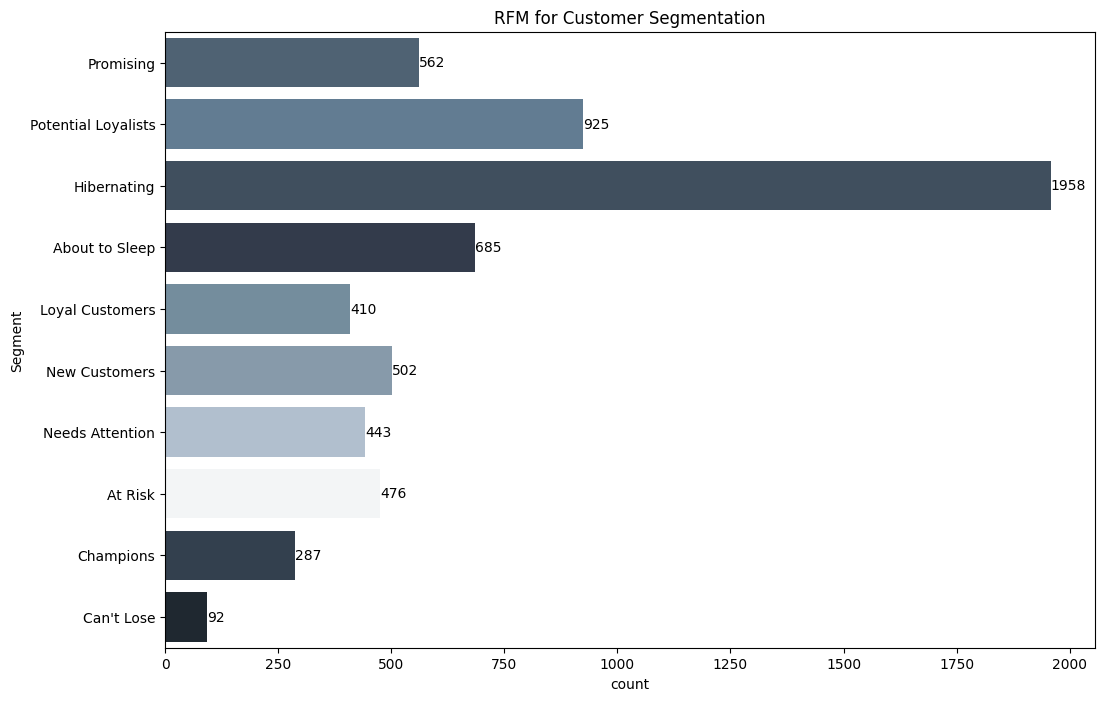

In [150]:
plt.figure(figsize=(12,8))
ax=sb.countplot(y='Segment',data=rfm1,
              palette=["#496379","#5A7D9A","#3B4F63","#2F3A4F","#6D8EA4","#819BB0",
                        "#ACBFD3", "#F3F5F7", "#2E4053", "#1C2833" ])
plt.title('RFM for Customer Segmentation')
for i in ax.containers:
    ax.bar_label(i)
plt.show()